<a href="https://colab.research.google.com/github/LexanderThakur/Cats_vs_Dogs_U/blob/main/CVDU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Todo**





* do pca and kmeans on base model



* Base Model does CNN encoder decoder -> PCA -> Kmeans

* Can try out trivial Augmentation







## 0.0 Device Agnostic Code

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##  1.0 Get Cats vs Dog Data

In [ ]:
from pathlib import Path
import zipfile
import requests

data_path = Path("data/")


image_path = data_path / "cvd"


if image_path.is_dir():
    print("Already exists")
else:
    print("Downloading...")

    image_path.mkdir(parents=True,
                     exist_ok=True)

    with open(data_path / "cvd.zip","wb") as f:
        request=requests.get("https://github.com/LexanderThakur/Cats_vs_Dogs_U/raw/main/cvd.zip")

        f.write(request.content)

        with zipfile.ZipFile(data_path / "cvd.zip","r") as z:
            z.extractall(data_path)
            print("Done lesssgoo baby")

Already exists


##   2.0 Data Prep and Explore

In [ ]:
import os


def walk_through_dir(dir_path):

    for dirpath,dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames) } directories and {len(filenames)} files in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 files in data/cvd
There are 2 directories and 0 files in data/cvd/train
There are 0 directories and 209 files in data/cvd/train/Dog
There are 0 directories and 209 files in data/cvd/train/Cat
There are 2 directories and 0 files in data/cvd/test
There are 0 directories and 88 files in data/cvd/test/Dog
There are 0 directories and 88 files in data/cvd/test/Cat


In [ ]:
train_dir= image_path/"train"
test_dir= image_path/"test"
train_dir

PosixPath('data/cvd/train')

### 2.1 Using PIL to show image

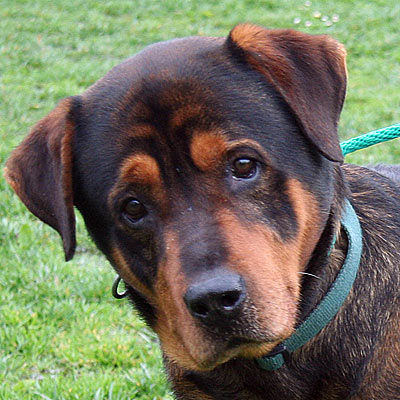

In [ ]:
import random

from PIL import Image

random.seed(42)

image_path_list= list(image_path.glob("*/*/*.jpg"))

random_image_path= random.choice(image_path_list)

img= Image.open(random_image_path)
img

### 2.2 Using matplot lib to show image

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

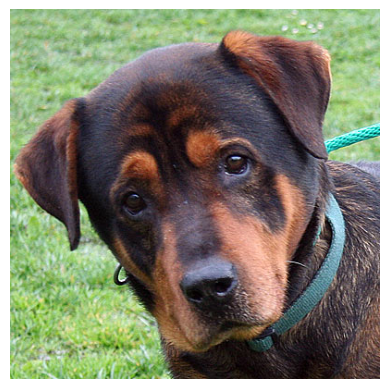

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array= np.asarray(img)

plt.imshow(img_as_array)
plt.axis(False)

## 3.0 Transforming data

In [ ]:
from torchvision import transforms


transform_1= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [ ]:
img_to_tensor=transform_1(img)
img_to_tensor.shape,img_to_tensor.dtype


(torch.Size([3, 64, 64]), torch.float32)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

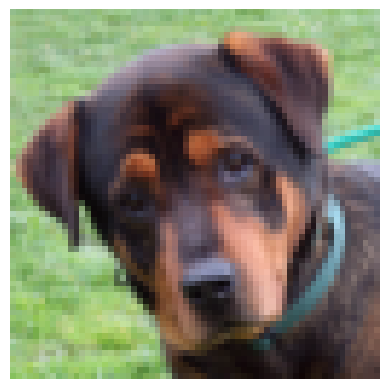

In [ ]:
plt.imshow(img_to_tensor.permute(1,2,0))
plt.axis(False)

## 4.0 Creating Dataset using Image Folder

In [ ]:
from torchvision import datasets

train_dataset= datasets.ImageFolder(
    root=train_dir,
    transform=transform_1
)

test_dataset= datasets.ImageFolder(
    root=test_dir,
    transform=transform_1
)

len(train_dataset), len(test_dataset)

(418, 176)

In [ ]:
train_dataset.samples[0]

('data/cvd/train/Cat/0.jpg', 0)

## 5.0 Dataset to dataloader

In [ ]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    num_workers=os.cpu_count()
)
len(train_dataset),len(train_dataloader)

(418, 14)

## 6.0 Model 0
inspired from https://ieeexplore.ieee.org/abstract/document/7732040



CNN -> PCA -> KMEANS

In [ ]:
import torch.nn as nn

class CVD_0(nn.Module):
    def __init__(self, input_features=3, hidden_features=32, output_features=3):
        super().__init__()

        # ===== ENCODER =====
        self.encoder = nn.Sequential(
            nn.Conv2d(input_features, hidden_features, kernel_size=3, stride=2, padding=1),   # 64x64 → 32x32
            nn.ReLU(),
            nn.Conv2d(hidden_features, hidden_features * 2, kernel_size=3, stride=2, padding=1),  # 32x32 → 16x16
            nn.ReLU(),
            nn.Conv2d(hidden_features * 2, hidden_features * 4, kernel_size=3, stride=2, padding=1), # 16x16 → 8x8
            nn.ReLU(),
            nn.Conv2d(hidden_features * 4, hidden_features * 8, kernel_size=3, stride=2, padding=1), # 8x8 → 4x4
            nn.ReLU()
        )

        # ===== DECODER =====
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_features * 8, hidden_features * 4, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_features * 4, hidden_features * 2, kernel_size=3, stride=2, padding=1, output_padding=1), # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_features * 2, hidden_features, kernel_size=3, stride=2, padding=1, output_padding=1),     # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_features, output_features, kernel_size=3, stride=2, padding=1, output_padding=1),         # 32x32 → 64x64
            nn.Sigmoid()  # normalize outputs between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### 6.1 Train Loop

In [ ]:
from tqdm.auto import tqdm

from timeit import default_timer as timer
model= CVD_0(input_features=3,hidden_features=32,output_features=3).to(device)

loss_fn=nn.MSELoss()

optimizer= torch.optim.Adam(model.parameters(),lr=0.001)

epochs=20
start_time=timer()
for epoch in tqdm(range(epochs)):
    model.train()
    total_loss=0
    for imgs,_ in train_dataloader:
        imgs=imgs.to(device)
        y_logits= model(imgs)

        loss= loss_fn(y_logits,imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()

    print(f"Epoch: {epoch} | Loss: {total_loss/len(train_dataloader)}")

end_time=timer()

print(f"Time Taken To Train : {end_time-start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.06516468950680324
Epoch: 1 | Loss: 0.06034326047769615
Epoch: 2 | Loss: 0.048401657225830216
Epoch: 3 | Loss: 0.04170750241194453
Epoch: 4 | Loss: 0.032200614522610395
Epoch: 5 | Loss: 0.02341471758804151
Epoch: 6 | Loss: 0.018786899346326078
Epoch: 7 | Loss: 0.018112608032034978
Epoch: 8 | Loss: 0.017265665012278726
Epoch: 9 | Loss: 0.01608874588938696
Epoch: 10 | Loss: 0.015065702144056559
Epoch: 11 | Loss: 0.014588642466281141
Epoch: 12 | Loss: 0.013724281918257475
Epoch: 13 | Loss: 0.01340749773329922
Epoch: 14 | Loss: 0.01395819682095732
Epoch: 15 | Loss: 0.012949890390570675
Epoch: 16 | Loss: 0.01242388951193009
Epoch: 17 | Loss: 0.012242940653647696
Epoch: 18 | Loss: 0.012424853896456105
Epoch: 19 | Loss: 0.011772732050823314
Time Taken To Train : 20.69789397799991


### 6.2 Visulize Learning

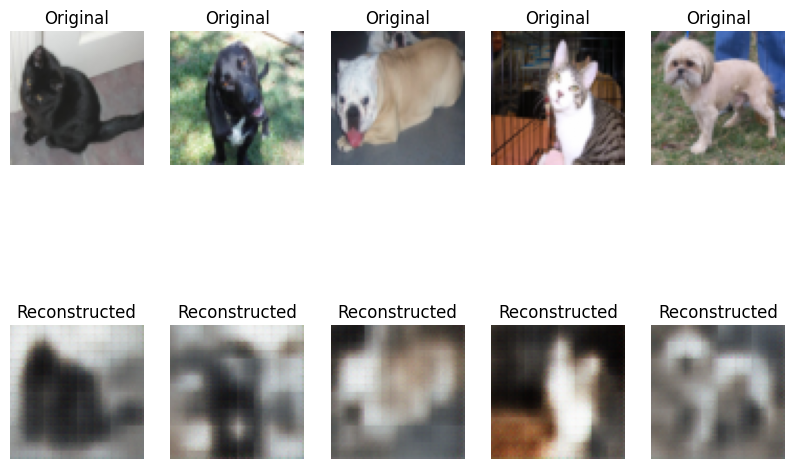

In [ ]:
model.eval()

imgs,_ = next(iter(train_dataloader))

imgs=imgs.to(device)

with torch.inference_mode():
    y_logits= model(imgs)


plt.figure(figsize=(10,7))
n=5

for i in range(n):
    # original
    plt.subplot(2,n,i+1)

    plt.imshow(imgs[i].cpu().permute(1,2,0))
    plt.title("Original")

    plt.axis(False)


    # reconstructed
    plt.subplot(2,n,i+n+1)
    plt.imshow(y_logits[i].cpu().permute(1,2,0))
    plt.title("Reconstructed")
    plt.axis(False)
plt.show()